## Surrogate Modeling: Supernova Tutorial

Data science offers numerous tools for modeling physical phenomena in an efficient, low-order fashion. In this tutorial, we will apply several of these tools (including PCA, DMD, and the neural ODE framework) to the simulation of a supernova. We assume that we have access to high-fidelity simulation data of the temperature field associated with the supernova, and our goal is to develop a fast model that can estimate its evolution based only on an initial condition.

In [1]:
# Import base python libraries
import math
import random
import os
import time

# Import the necessary array-handling libraries
import h5py
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.io import loadmat
from scipy.io import savemat

# Import additional NN training modules
from sklearn.decomposition import PCA

# Import Pytorch for neural network training
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import PyTorch differential equation library
from torchdiffeq import odeint

### Part 0: Loading and visualizing the data

As a starting point, we will load in the dataset and display a sample snapshot of the temperature field. Note that our dataset consists of 59 time-resolved snapshots of the scalar temperature field on a 64 x 64 grid.

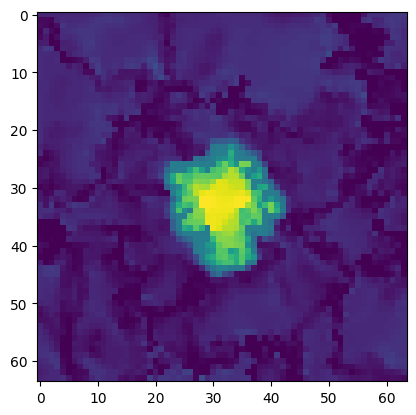

In [2]:
# Select the trajectory of interest (note: there are 16 trajectories stored in each hdf5 file)
traj = 3

# Load images associated with the temperature field
! mkdir /tmp/data
! cp -r /scratch1/10386/lsmith9003/share/tutorialData/supernova/supernova_explosion_Msun_0.1_dim64_file_10.hdf5 /tmp/data/.
with h5py.File('/tmp/data/supernova_explosion_Msun_0.1_dim64_file_10.hdf5','r') as data:
	yInput = data['t0_fields']['temperature'][traj,:]

# Extract a 2D slide from the 3D dataset 
# Note that as loaded, the data is organized as: time x dim0 x dim1 x dim2
x_slice = 32
yInput = np.squeeze(yInput[:,x_slice,:,:])

# As a final step we will take the log of the dataset. This helps normalize 
# the data, as the temperature range spans several magnitudes.
yInput = np.log(yInput)

# Downsample the data in time. This will give us a way of separating the data
# into test data and train data. However, keep in mind that for this example, the data
# must be sampled at a regular time step, so we are limited to a 50-50 test/train split.
# There are time series methods that extend to irregularly sampled in time,
# but they are somewhat outside the scope of this example.
#yInput_all = yInput
#yInput = yInput[::2]

# Figure 0: Display one image to give us an idea of the flowfield
yPlot = np.reshape(np.squeeze(yInput[random.randint(0,len(yInput)-1)]),newshape=(64,64))
fig0 = plt.figure()
plt.imshow(yPlot)
plt.show()

### Part 1: Principal Component Analysis (PCA)

Principal component analysis often serves as a useful starting point for many surrogate modeling efforts. By itself, PCA does not produce a surrogate model; however, it does provide a way for us to visualize our data in state space, and offers insight into the level of complexity inherent to our dataset. We perform PCA on the complete supernova dataset and display the first three principal components in the space below. 

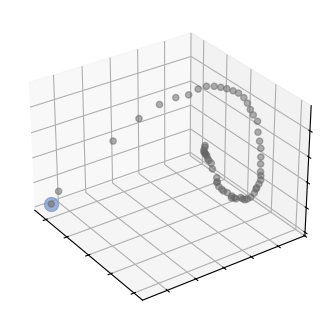

In [3]:
# Define the number of PCA modes to retain
numPCA = int(10)

# Flatten the input tensor for use with PCA
X = torch.flatten(torch.tensor(yInput),1)
X = X.detach().numpy()
#X_all = torch.flatten(torch.tensor(yInput_all),1)
#X_all = X_all.detach().numpy()

# Initialize PCA object
pca = PCA(n_components=10,svd_solver='auto')

# Perform PCA on the cylinder dataset
pca.fit(X-np.mean(X,axis=0))
A = pca.transform(X-np.mean(X,axis=0))

# Figure 1: Display the first three leading PCA components
fig1 = plt.figure(figsize=(5.5,4))
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(A[:,0],A[:,1],A[:,2],marker='o',color=(0.4,0.4,0.4),alpha=0.5)
ax1.scatter(A[0,0],A[0,1],A[0,2],marker='o',color=(0.5,0.6,0.8),alpha=0.75,s=100)
plt.setp( ax1.get_xticklabels(), visible=False)
plt.setp( ax1.get_yticklabels(), visible=False)
plt.setp( ax1.get_zticklabels(), visible=False)
ax1.view_init(elev=30, azim=-35, roll=0)
plt.show()

We see that our data is quite organized when displayed in state space. Our system begins at some initial state (blue dot), moves away from that initial state following the onset of the supernova, then begins to spiral inward as it reaches a new equilibrium. It will be helpful to keep this picture of the data in my mind as we explore various surrogate modeling techniques; in fact one of our goals will be to recreate this trajectory starting from the initial condition.

Note that we can also use PCA to give us insight into the degree of complexity. Let us see how well the leading PCA modes are able to capture variances contained in our dataset. 

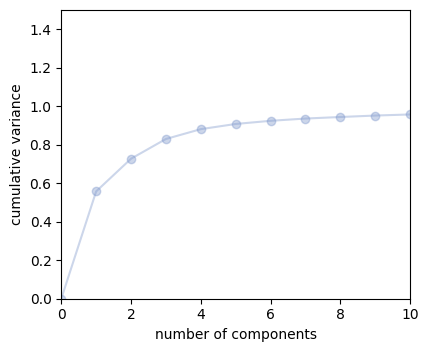

In [4]:
# Extract singular values and determine variance distribution
sigma = pca.explained_variance_ratio_
sigmaCumulative = np.zeros((np.shape(sigma)))
for ind in range(0,len(sigma)):
	sigmaCumulative[ind] = np.sum(sigma[0:(ind+1)])
sigmaCumulative = list(sigmaCumulative)
sigmaCumulative.insert(0,0)

# Figure 2: Display the distribution of variance among the principal components
fig2 = plt.figure(figsize=(1.5*3,1.5*2.5))
ax2 = fig2.add_subplot()
plt.plot(np.arange(0,11,1),sigmaCumulative,marker='o',color=[0.5,0.6,0.8],alpha=0.4)
plt.xlabel('number of components')
plt.ylabel('cumulative variance')
ax2.set_xlim(0,10)
ax2.set_ylim(0,1.5)
plt.show()


Consistent with our visualization, the singular values reveal that our dataset possesses a simple structure. The figure above suggests that nearly 90% of the data variance can be captured with roughly five principal components.

### Part 2: Dynamic Mode Decomposition (DMD)

The dynamic mode decomposition (DMD) is perhaps the most popular method of data-driven surrogate modeling. DMD models the state dynamics as a discrete dynamical system:

x(time + dt) = A * x(time)

The goal of DMD is to estimate the operator A that advances the state of the system forward in time. The key ingredient of DMD is to assume that this operator is linear, such that we can write an analytical solution for the system based on the matrix A. The following code walks through the standard DMD algoirthm, as applied to the supernova data.

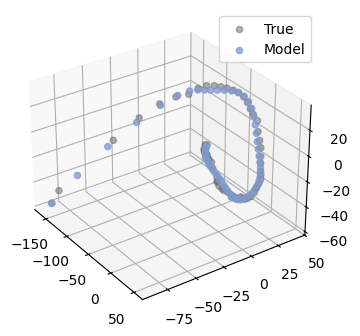

In [5]:
# Step 0: Pre-process the data matrix. Note that this step creates two data matrices: (1) the data matrix X at time t, and (2) the data matrix Xp at time t+dt.
XDMD = np.transpose(X,[1,0])
Xp = XDMD[:,1:]
XDMD = XDMD[:,0:-1]

# Step 1: Compute the SVD of the dataset and truncate
r = numPCA
U,Sigma,VT = np.linalg.svd(XDMD,full_matrices=False)
Ur = U[:,:r]
Sigmar = np.diag(Sigma[:r])
VTr = VT[:r,:]

# Step 2: Compute the transformed linear operator
Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xp @ VTr.T).T).T

# Step 3: Eigen-decomposition of the transformed linear operator
Lambda, W = np.linalg.eig(Atilde)
Lambda = np.diag(Lambda)

# Step 4: Compute DMD Modes
Phi = Xp @ np.linalg.solve(Sigmar.T,VTr).T @ W
alpha1 = Sigmar @ VTr[:,0]
b = np.linalg.solve(W @ Lambda,alpha1)

# Step 5: Compute the time evolution of the process, based on the initial condition, and the DMD model
xPred = np.zeros(np.shape(XDMD))
xPred[:,0] = XDMD[:,0]
for k in range(1,len(XDMD[0,:])):
	temp = Phi @ np.diag(np.exp(k*np.log(np.diag(Lambda)))) @ b
	xPred[:,k] = np.real(temp)     
    
# Figure 4: plot the results of the DMD simultion
XDMD = np.transpose(XDMD,[1,0])
xPred = np.transpose(xPred,[1,0])
A_DMD = pca.transform(xPred-np.mean(xPred,axis=0))

fig4 = plt.figure(figsize=(5.5,4))
ax4 = fig4.add_subplot(projection='3d')
ax4.scatter(A[:,0],A[:,1],A[:,2],marker='o',color=(0.4,0.4,0.4),alpha=0.5)
ax4.scatter(A_DMD[:,0],A_DMD[:,1],A_DMD[:,2],marker='o',color=(0.5,0.6,0.8),alpha=0.75)
ax4.view_init(elev=30, azim=-35, roll=0)
plt.legend(['True','Model'])
plt.show()

While DMD produces some inaccuracies at early times, we see that the modeled trajectory closely matches the true data quite well over very long times. This demonstrates one major advantage of DMD. While it is a linear method, the mixed analytical-numerical nature of DMD helps ensure the long term stability of any models produced in this framework. At the same time, we see that the DMD model appears to "smooth" out the trajectory's small-scale details. This likely a consequence of the linear assumption at the core of DMD, along with our chosen number of PCA modes, and becomes a more significant problem as the original dataset becomes more complex.

### Part 3: Sparse Identification of Nonlinear Dynamics (SINDy)

Sparse identification of nonlinear dynamics (SINDy) is a very simple modeling technique that is often paired with PCA. It involves fitting a dynamical trajectory to a series of user-defined library functions. That is, SINDy solves the following equation for xi:

dx_dt = theta(x) * xi

Where x represents the state of our system (known from data), dx_dt is the time derivative of our state (also known from data), and theta(x) is a user-defined matrix of library functions, evaluated at the current value of x. By integrating this equation forward in time, we arrive at a surrogate model for the system dynamics, with a complexity determined by the number of terms in theta(x). 

In the space below, we demonstrate a simple application of SINDy using the first ten PCA modes as the system state.

In [6]:
# Define our system state (in this case, it is the first 10 PCA modes)
x = A[:,0:numPCA]

# Define a matrix of library functions
# Note that this line is user defined. We are only including linear terms here, but this line could be edited to include x^2 x[:,0]*x[:,1], etc.
theta = np.concatenate((np.ones((len(x[:,0]),1)),x),axis=-1)

# Compute the time derivative of the system state
dt = float(1)
dx_dt = np.zeros(np.shape(x))
dx_dt[0] = (x[1]-x[0])/dt
dx_dt[1:-1] = (x[2:]-x[0:-2])/(2*dt)
dx_dt[-1] = (x[-1]-x[-2])/dt

# Solve for the coefficient matrix
xi = np.linalg.lstsq(theta,dx_dt,rcond=None)[0]

We now have everything we need (a system state, a library function matrix, and a coefficient matrix) to construct a surrogate model of the system. Let us use this model to simulate the evolution of our PCA coefficients, starting from the initial condition. We can compare our surrogate trajectory with the "true" trajectory plotted previously.

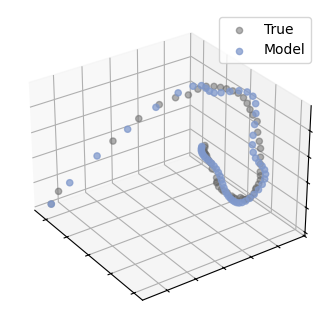

In [7]:
# Define properties of the SINDy evaluation
itTot = int(len(X)*100.)
x = np.zeros((itTot,numPCA))

# Extract the initial condition from PCA coefficients
x[0,:] = A[0,0:numPCA]

# Integrate the intial condition over time with a simple Euler's method
for it in range(0,itTot-1):
    xCur = x[it,:]
    xCur = np.reshape(xCur,newshape=(1,len(xCur)))
    theta = np.concatenate((np.ones((1,1)),xCur),axis=-1)
    dx_dt = theta@xi
    x[it+1,:] = x[it,:] + dx_dt * dt/100

# Adjust size of model to compare with original data
x = x[::100]

# Figure 3: Display the modeled trajectory overlaid with the "true" trajectory 
fig3 = plt.figure(figsize=(5.5,4))
ax3 = fig3.add_subplot(projection='3d')
ax3.scatter(A[:,0],A[:,1],A[:,2],marker='o',color=(0.4,0.4,0.4),alpha=0.5)
ax3.scatter(x[:,0],x[:,1],x[:,2],marker='o',color=(0.5,0.6,0.8),alpha=0.75)
plt.setp( ax3.get_xticklabels(), visible=False)
plt.setp( ax3.get_yticklabels(), visible=False)
plt.setp( ax3.get_zticklabels(), visible=False)
ax3.view_init(elev=30, azim=-35, roll=0)
plt.legend(['True','Model'])
plt.show()

The model does follow the overall path of the trajectory, but notice the appearance of oscillations near the trajectory's end. Why does this happen? Could this have been solved by adjusting the library functions?

### Part 4: Neural Ordinary Differential Equation (Neural ODE)

The final framework discussed in this tutorial is that of Neural Ordinary Differential Equations (neural ODE's). A somewhat more recent addition to the field of surrogate modeling, neural ODE's essential solve the same discrete dynamical system as DMD; however, neural ODE's make use of a neural network (rather than matrix multiplication) to model the operator on the RHS. This allows the model to capture nonlinearities in the RHS of the governing equation, a crucial feature when handling highly complex datasets. In the code below, we load a pre-trained neural ODE for the cylinder flow data and compare its predicted trajectory with the original dataset. Pay close attention to how the neural network is evaluated; the neural ODE is essentially providing a (hopefully faster and more stable) replacement for the governing equations of the simulation.

GPU not available. Using CPU.


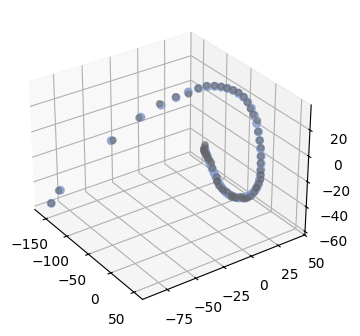

In [8]:
# Define the linear ODE Function class
class ODEFunc(nn.Module):
	def __init__(self):
		super().__init__()

		# Damping matrix (helps with the stability of the model)
		self.A = nn.Parameter(-0.05*torch.abs(torch.diag(torch.tensor([
			57.05632, 31.482574, 24.466896, 17.26774, 12.547659, 9.773845,
  			8.289702, 6.8493795, 6.631533, 5.7716274])/57.05632)),requires_grad=False)

		# Define the neural ODE architecture
		self.ode_nonlinear = nn.Sequential(
			nn.Linear(10,20),
			nn.Tanh(),
			nn.Linear(20,40),
			nn.Tanh(),
			nn.Linear(40,20),
			nn.Tanh(),
			nn.Linear(20,10),
			)

	def forward(self, t, x):
		return torch.matmul(x,self.A) + self.ode_nonlinear(x)


# Define our system state (in this case, it is the first 10 PCA modes)
numPCA = int(10)
yInput = A[:,0:numPCA]/57.05632

# Define total number of images in the dataset
imTot = len(yInput)

# Convert the test/train data to PyTorch tensor format
yInput = torch.tensor(yInput,dtype=torch.float32)

# Instantiate the ode function
func = ODEFunc()

# Copy the pretrained model and load the appropriate weights
! mkdir /tmp/models
! cp -r /scratch1/10386/lsmith9003/share/tutorialModels/supernova/func.pth /tmp/models/.
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print("GPU is available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")
func.load_state_dict(torch.load('/tmp/models/func.pth',weights_only=True,map_location=torch.device(device)))

# Define the time range of evaluation (note that the ode was trained such that dt = 1 corresponds to one
# time step)
dt = torch.tensor(list(np.arange(0,59,1)),dtype=torch.float32)

# Evaluate the ODE
yPred = odeint(func,yInput[0],dt)
yPred = 57.05632*yPred.detach().numpy()

# Figure 5: plot the results of the neural ODE simulation
fig5 = plt.figure(figsize=(5.5,4))
ax5 = fig5.add_subplot(projection='3d')
ax5.scatter(A[:,0],A[:,1],A[:,2],marker='o',color=(0.4,0.4,0.4),alpha=0.5)
ax5.scatter(yPred[:,0],yPred[:,1],yPred[:,2],marker='o',color=(0.5,0.6,0.8),alpha=0.75,s=30)
ax5.view_init(elev=30, azim=-35, roll=0)
plt.show()

We see that the neural ODE performs the best of our three methods. This is largely because it allows for nonlinearity in the dynamics without requiring the user to select an appropriate set of library functions; this kind of flexibility becomes increasingly significant as the dataset becomes more complicated. For this reason, the development of stable neural ODE architectures, and processes for streamlining their architecture and training, is a major theme in the surrogate modeling literature.